<a href="https://colab.research.google.com/github/thiagofuruchima/enem_ds/blob/main/enem_data_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ENEM - Data Study

A statistical inference study about brazilian high school students using 2019 ENEM dataset. We'll be appyling both bootstrap and standard t-test hypothesis testing, and compare the results.

##1. Problem Understanding

We're going to use a random sample of the ENEM data (Brazil's SAT like exam) to answer the following questions regarding brazilian high school students.

1 - Do brazilian students declared themselves as white skinned have higher average scores than those self declared as brown skinned? Do they also have higher average family income?

2 - Do brazilian students declared themselves as brown skinned have higher average scores than those self declared as black? Do they also have higher average family income?

3 - Do brazilian female students have higher essay average scores than male students? Do they also have higher average family income?

4 - Do brazilian students who chose 'english' as a foreign language have higher average scores than those who chose 'spanish'? Do they also have higher average family income?

## 2. Data Understanding

We're using a 0.1% random sample of the whole ENEM exam dataset. The whole dataset can be accessed in [Dados Abertos INEP](https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos).

First, let's load the dataset and take a look at it.

In [71]:
# laod the libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
# from statsmodels import stats

In [72]:
# read the sample dataset
df = pd.read_csv("https://github.com/thiagofuruchima/enem_ds/raw/main/data/enem_random_sample_01_percent.csv")

In [73]:
# check the row/column count
df.shape

(5095, 136)

In [74]:
# check the first 5 rows
df.head()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,NO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,SG_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,CO_UF_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,...,TX_RESPOSTAS_CH,TX_RESPOSTAS_LC,TX_RESPOSTAS_MT,TP_LINGUA,TX_GABARITO_CN,TX_GABARITO_CH,TX_GABARITO_LC,TX_GABARITO_MT,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,190002290964,2019,2927408,Salvador,29,BA,30,M,1,3,1,2927408.0,Salvador,29.0,BA,1,9,1,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,ECEADCABDBDCDBEECDAEDACEBDDDBAECBCAEBECDBBECC,EDACD99999DCBDBCCABEDACECBAEBADDACEBEDCADDBEBD...,CEBBBDDBACEDCDABBDEBDADDCBBBCAEDDAAEDBCCADBCB,0,DEADBAAAEBEECEBCBCBCBDADAEABCEDDDDADCBEECACBC,BACCCBABBADCBCEEEBCACACEEDBCCADBEADBADBBBACDB,BDABEABCADBCBAADDBECDAAECDAECBECBCCDEEAAADDBBC...,AADDDBEEEBEDDBEBACABCDBABECECACAECDCBDCCEDCDA,1.0,80.0,120.0,80.0,140.0,100.0,520.0,C,B,B,B,3,B,A,B,C,A,A,B,A,A,A,A,A,A,B,B,A,B,B,B,B
1,190004057495,2019,3550308,São Paulo,35,SP,29,F,1,3,1,2913606.0,Ilhéus,29.0,BA,1,11,1,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,CCADAECCDBACABAEDAEABEDEACBCBCAABEDDCEDBEACEA,99999CABDDDBEDBCECEBACBDCBEEDECBAEEEACEACDCECA...,CDCBADABCCDBEACEDEDACBEDCBDBABAAEDCCBEDBABEDB,1,DADCCEBBCCACBEEBEEBACBCDDDDADBCBBCEAEADEADAAE,ACACEEBCCBABADBBBACDBBACCCCADCEBADCBEEDBBEADB,EBBADCABDABACBCEBDEEAAADDBECDECDDBADBCDAAECBCC...,DBEBACABCDBABECEEEDCBDCCEDCDABEDAADDDECACAECB,1.0,140.0,180.0,120.0,120.0,100.0,660.0,H,H,C,F,6,C,A,B,C,A,A,B,A,A,A,B,A,A,B,B,A,D,A,B,B
2,190002548758,2019,2304400,Fortaleza,23,CE,31,M,1,3,1,2304400.0,Fortaleza,23.0,CE,1,13,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,BCACABABBABCECEEABCCCABDEDBCCADEEEDDADBEEAEAB,BDABE99999BCBADDDBEEDAAEBABCCBECBCCAEBAADDADBC...,BACAABDBDECBAECBABBACEAEDDEAECDBEACCCBDCCEDA*,0,BEEAAEBEEBADEADDADAEABCEDDDBCBCBCCACBCDADCCEB,BACCCBABBADCBCEEEBCACACEEDBCCADBEADBADBBBACDB,BDABEABCADBCBAADDBECDAAECDAECBECBCCDEEAAADDBBC...,BEDEEEAADBEBACABCDBABECECACADCBDCCEDCDABECDDD,1.0,160.0,140.0,120.0,160.0,120.0,700.0,E,E,E,D,4,D,A,B,B,B,A,B,A,B,A,A,A,A,B,A,A,E,B,C,B
3,190001162162,2019,2304400,Fortaleza,23,CE,20,F,1,1,1,2304400.0,Fortaleza,23.0,CE,1,2,1,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,C,B,B,4,C,A,B,B,A,A,B,A,A,A,B,A,A,B,A,A,C,A,A,B
4,190001424877,2019,2807501,Tomar do Geru,28,SE,18,F,1,3,1,2802106.0,Estância,28.0,SE,3,0,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,B,A,A,4,B,A,B,C,A,B,B,A,A,A,A,A,A,B,B,A,C,A,A,A


In [75]:
# check the last 5 rows
df.tail()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,NO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,SG_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,CO_UF_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,...,TX_RESPOSTAS_CH,TX_RESPOSTAS_LC,TX_RESPOSTAS_MT,TP_LINGUA,TX_GABARITO_CN,TX_GABARITO_CH,TX_GABARITO_LC,TX_GABARITO_MT,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
5090,190004067563,2019,3550308,São Paulo,35,SP,17,M,1,1,1,3550308.0,São Paulo,35.0,SP,2,0,2,1.0,0,35001659.0,3550308.0,São Paulo,35.0,SP,2.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,...,ACCCEECBADACDBAECCDAECBACDBEEECCCBBADEDBAADAE,99999DAACEDBCEACBACECBDBBAAADCBDAEDCDDCEBEEECD...,ABBACCACAEDAEDCBADADCAEACBCCBBCECEBBABADDDCEC,1,DEADBAAAEBEECEBCBCBCBDADAEABCEDDDDADCBEECACBC,EEBCEEDBADBBCBABCCADCEBACDBBACCACACBEADBBADCB,ADBBEDCABAABBCBCDAAECDDDBAAAECADECDCEBDEEAECBD...,AADDDBEEEBEDDBEBACABCDBABECECACAECDCBDCCEDCDA,1.0,120.0,120.0,120.0,120.0,0.0,480.0,D,D,C,F,3,B,A,B,C,A,A,B,B,B,A,B,A,A,C,B,B,D,B,A,B
5091,190005942525,2019,4315909,Rodeio Bonito,43,RS,18,F,1,1,1,4315909.0,Rodeio Bonito,43.0,RS,2,0,2,1.0,0,43116019.0,4315909.0,Rodeio Bonito,43.0,RS,2.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,...,BDCBECAACDBEDBEACBEDABCEACEBDAEBDACCECAEBAEDB,99999EDEEBCAEBCEDCDDAEABADCEBDDADBECBDBEEBABCA...,DECDBBDCCEECBEBECBACDBEADCEBADBCADCEABAEDBAEA,1,DADCCEBBCCACBEEBEEBACBCDDDDADBCBBCEAEADEADAAE,CBABADBBCEEEBCBADCBEEDBBEADBBACDBBACCCCADACAC,BBEDABDACACBABAECBBCCADCEBDBBCDDEEAAADDBECDECA...,DBEBACABCDBABECEEEDCBDCCEDCDABEDAADDDECACAECB,1.0,120.0,120.0,120.0,120.0,140.0,620.0,H,F,F,D,2,D,A,B,C,B,A,B,A,B,A,B,A,A,B,A,A,C,A,B,B
5092,190002772261,2019,2609105,Machados,26,PE,17,M,1,1,1,2611606.0,Recife,26.0,PE,2,0,2,NaN,0,26070090.0,2609105.0,Machados,26.0,PE,2.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,...,ABCACADAACABDDECCEBAADDCBDDDABEEBDECBCBABDCAE,AAAAA99999CDAECAECCDEBCEADCDEBCBAEDAADEEACBDCA...,ECEBCAADADACDACAEDEDEBDDEDABEDBADEDACCECABDCE,0,DEADBAAAEBEECEBCBCBCBDADAEABCEDDDDADCBEECACBC,CBABADBBCEEEBCBADCBEEDBBEADBBACDBBACCCCADACAC,BBEDABDACACBABAECBBCCADCEBDBBCDDEEAAADDBECDECA...,AADDDBEEEBEDDBEBACABCDBABECECACAECDCBDCCEDCDA,1.0,140.0,160.0,160.0,180.0,160.0,800.0,C,A,A,A,8,A,A,B,D,A,A,B,A,A,A,A,A,A,B,A,A,B,A,A,A
5093,190001276489,2019,2927705,Santa Cruz Cabrália,29,BA,24,M,0,5,1,2903300.0,Barro Preto,29.0,BA,1,6,1,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,B,C,F,9,C,A,B,D,A,A,B,A,A,A,A,A,A,B,B,A,D,A,A,B
5094,190005984465,2019,3550308,São Paulo,35,SP,19,F,1,3,2,NaN,NaN,NaN,NaN,1,2,1,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,AEBECCBBAAABBDDDCBBAEBCEDCACCBCCADB..CBAAACCC,99999AEDEECECBBCCCBBDDECBBAAACCAACACADECBDEACC...,BDBDEDBDCBBCBEBADBCBDDCCCBECBECBCEBCBCACCEDEB,1,DADCCEBBCCACBEEBEEBACBCDDDDADBCBBCEAEADEADAAE,EEBCEEDBADBBCBABCCADCEBACDBBACCACACBEADBBADCB,ADBBEDCABAABBCBCDAAECDDDBAAAECADECDCEBDEEAECBD...,DBEBACABCDBABECEEEDCBDCCEDCDABEDAADDDECACAECB,1.0,120.0,100.0,80.0,80.0,60.0,440.0,E,F,F,D,5,I,A,B,C,B,B,B,A,B,B,B,A,A,B,A,A,E,A,C,B


It look's like the dataset is alright!

Now, lets check the datatypes. Since there are more than a hundred columns, and we'll only use few of them, we're going to check only the important ones in our context. Also, we'll be translating these columns to english.

In [76]:
# translate only the columns we'll be using on our analysis
df.rename(columns={'NU_IDADE':'AGE',
                   'TP_SEXO':'GENDER',
                   'TP_COR_RACA':'SKIN_COLOR',
                   'TP_LINGUA':'FOREIGN_LANGUAGE',
                   'NU_NOTA_CN':'GRADE_NATURAL_SCIENCES',
                   'NU_NOTA_CH':'GRADE_HUMAN_SCIENCES',
                   'NU_NOTA_LC':'GRADE_LANGUAGE_SCIENCES',
                   'NU_NOTA_MT':'GRADE_MATH_SCIENCES',
                   'NU_NOTA_REDACAO':'GRADE_ESSAY'}, inplace=True)

In [77]:
# define the important columns for our analysis
important_columns = ['AGE', 'GENDER',  'SKIN_COLOR',
                     'FOREIGN_LANGUAGE','GRADE_NATURAL_SCIENCES','GRADE_HUMAN_SCIENCES',
                     'GRADE_LANGUAGE_SCIENCES','GRADE_MATH_SCIENCES','GRADE_ESSAY']

Lets check the first rows again, but now, only the important ones.

In [78]:
df[important_columns].head()

,AGE,GENDER,SKIN_COLOR,FOREIGN_LANGUAGE,GRADE_NATURAL_SCIENCES,GRADE_HUMAN_SCIENCES,GRADE_LANGUAGE_SCIENCES,GRADE_MATH_SCIENCES,GRADE_ESSAY
0,30,M,3,0,406.9,449.9,530.0,408.0,520.0
1,29,F,3,1,415.2,521.1,529.5,544.2,660.0
2,31,M,3,0,566.3,626.9,607.7,612.3,700.0
3,20,F,1,1,NaN,NaN,NaN,NaN,NaN
4,18,F,3,1,NaN,NaN,NaN,NaN,NaN


It look's like some values are 'coded' so we need to 'translate' that.

In [79]:
df['GENDER'] = df['GENDER'].map({'M':'Male',
                  'F':'Female'})

df['SKIN_COLOR'] = df['SKIN_COLOR'].map({0:'Not Informed',
                     1:'White',
                     2:'Black',
                     3:'Brown',
                     4:'Yellow',
                     5:'Indigenous'})

df['FOREIGN_LANGUAGE'] = df['FOREIGN_LANGUAGE'].map({0:'English',
                     1:'Spanish'})

Now, lets check the datatypes.

In [80]:
# check the columns types
df[important_columns].dtypes

AGE                          int64
GENDER                      object
SKIN_COLOR                  object
FOREIGN_LANGUAGE            object
GRADE_NATURAL_SCIENCES     float64
GRADE_HUMAN_SCIENCES       float64
GRADE_LANGUAGE_SCIENCES    float64
GRADE_MATH_SCIENCES        float64
GRADE_ESSAY                float64
dtype: object

Most of them are correct. But some categorical types were handled incorrectly. Let's fix that.

In [81]:
# change the type of columns for 'GENDER', 'RACE' and 'FOREING LANGUAGE' to category
df['GENDER'] = df['GENDER'].astype('category')
df['SKIN_COLOR'] = df['SKIN_COLOR'].astype('category')
df['FOREIGN_LANGUAGE'] = df['FOREIGN_LANGUAGE'].astype('category')

Let's check for duplicated and null values, as these can have a huge impact on our analysis.

In [82]:
# check for duplicates
df.duplicated().sum()

0

No duplicates! What about null values?

In [83]:
# check for missing values
df[important_columns].isna().sum()

AGE                           0
GENDER                        0
SKIN_COLOR                    0
FOREIGN_LANGUAGE              0
GRADE_NATURAL_SCIENCES     1391
GRADE_HUMAN_SCIENCES       1181
GRADE_LANGUAGE_SCIENCES    1181
GRADE_MATH_SCIENCES        1391
GRADE_ESSAY                1181
dtype: int64

Altought we don't have any duplicates, we've got a lot of missing values on our dataset. Let's take a look at these cases, to see if we can spot a reason for that.

In [84]:
# check the rows with na in selected columns
df[df[important_columns].isna().any(axis=1)][important_columns]

,AGE,GENDER,SKIN_COLOR,FOREIGN_LANGUAGE,GRADE_NATURAL_SCIENCES,GRADE_HUMAN_SCIENCES,GRADE_LANGUAGE_SCIENCES,GRADE_MATH_SCIENCES,GRADE_ESSAY
3,20,Female,White,Spanish,NaN,NaN,NaN,NaN,NaN
4,18,Female,Brown,Spanish,NaN,NaN,NaN,NaN,NaN
6,22,Male,Brown,Spanish,NaN,NaN,NaN,NaN,NaN
9,55,Male,Black,English,NaN,NaN,NaN,NaN,NaN
15,16,Female,Brown,Spanish,416.1,NaN,NaN,385.6,NaN
...,...,...,...,...,...,...,...,...,...
5069,18,Female,White,English,NaN,379.0,440.6,NaN,360.0
5077,21,Male,White,English,NaN,436.0,451.4,NaN,320.0
5084,22,Male,Black,English,NaN,NaN,NaN,NaN,NaN
5085,21,Male,White,Spanish,NaN,NaN,NaN,NaN,NaN


It looks like the everyone has their personal information complete, but not everybody has a score. This is because students have to fill a form in order to take the exam, but some of them, don't actually take the test.

Since our analysis is focused only on those who completed the whole exam, we're going to discard the rows with missing information for the grades.

In [85]:
grades_columns = ['GRADE_NATURAL_SCIENCES','GRADE_HUMAN_SCIENCES','GRADE_LANGUAGE_SCIENCES','GRADE_MATH_SCIENCES','GRADE_ESSAY']
df.dropna(subset=grades_columns, inplace=True)

Now, let's do some graphical EDA. For the numericals, we're going to plot the distribution, for the categoricals, the count/proportion.

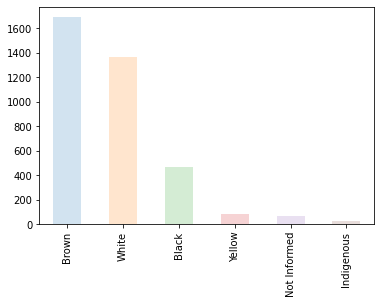

In [86]:
# Plot the 'Skin Color' count
df['SKIN_COLOR'].value_counts(dropna=False).plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'], alpha=.2)
plt.show()

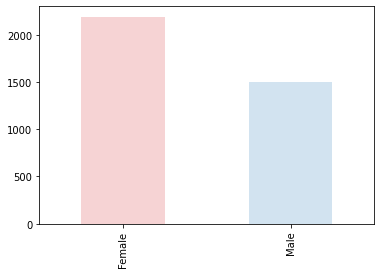

In [87]:
# Plot the gender count
df['GENDER'].value_counts().plot(kind='bar', color=['#d62728', '#1f77b4'], alpha=.2)
plt.show()

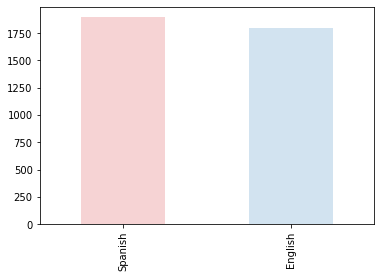

In [88]:
# Plot the 'foreign language' count
df['FOREIGN_LANGUAGE'].value_counts().plot(kind='bar', color=['#d62728', '#1f77b4'], alpha=.2)
plt.show()

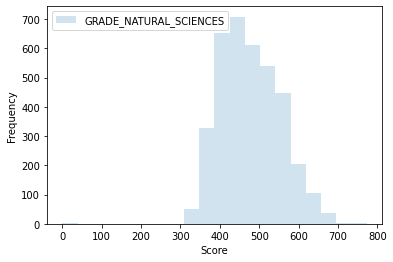

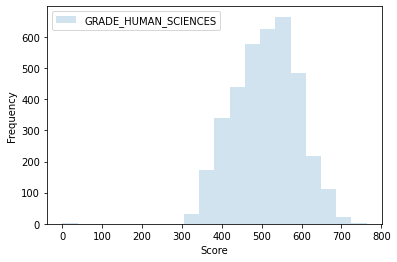

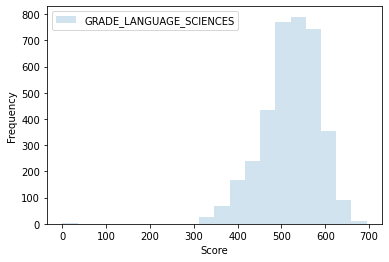

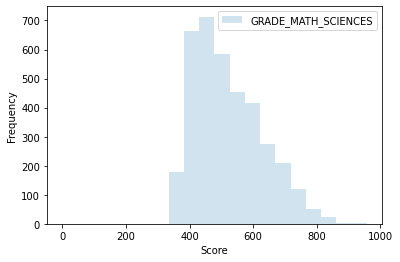

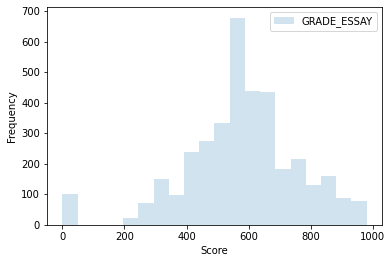

In [89]:
# Plot a histogram for the grades
for column in grades_columns:
  df[column].plot(kind='hist', alpha=0.2, bins=20)
  plt.xlabel("Score")
  plt.legend()
  plt.show()

 ## 3. Data Preparation

Now, let's prepare some data for our analysis. Also we'll define the significance level (alpha) for our tests, and the function we're going to be using for getting the bootstrap distributions.

In [90]:
# create a column with the total score
df['TOTAL_SCORE'] = df[grades_columns].sum(axis=1)

In [91]:
# create a flag to inform if the family average income is more than 2 brazilian minimum wages
df['AVERAGE_INCOME_MORE_2WAGES'] = ~df['Q006'].isin(['A','B','C','D'])

In [92]:
# define our significance level as 5%
alpha = 0.05

In [93]:
def get_bootstrap_means(group1, group2):
#   """ Compute N bootstrap sample means for for two groups"""
  n_bootstraps = 1000
  group1_mean_list, group2_mean_list = [], []
  for _ in range(n_bootstraps):
    # Take the bootstrap sample for each group independently
    group1_mean = group1.sample(group1.shape[0], replace=True).mean()
    group2_mean = group2.sample(group2.shape[0], replace=True).mean()
    group1_mean_list.append(group1_mean)
    group2_mean_list.append(group2_mean)
  
  return pd.Series(group1_mean_list), pd.Series(group2_mean_list)

## 4. Bootstrap Hypothesis Tests

### 4.1. Do brazilian students declared themselves as white skinned have higher average scores than those self declared as brown skinned?

To answer this question, we're going to perform the following hypothesis test:



$$ H_0 : \mu_{score\_white} \le \mu_{score\_brown} $$

$$ H_1 : \mu_{score\_white} \gt \mu_{score\_brown} $$

First, we're going to generate 10.000 bootstrap means for each group, and use that to empirically create the sample distribution for the mean score.

In [94]:
white_mean_score_list, brown_mean_score_list = get_bootstrap_means(df.query('SKIN_COLOR=="White"')['TOTAL_SCORE'], df.query('SKIN_COLOR=="Brown"')['TOTAL_SCORE'])

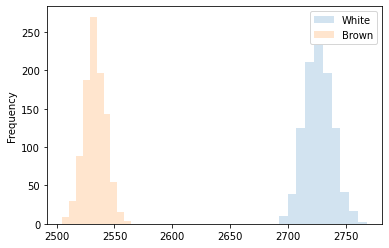

In [95]:
white_mean_score_list.plot(kind='hist', alpha=.2, label="White")
brown_mean_score_list.plot(kind='hist', alpha=.2, label="Brown")
plt.legend()
plt.show()

Let's calculate the p-value and the 'bootstrap equivalent' t-statistic for our hypothesis.

In [96]:
# compute the probability of h0
pvalue_boot_1 = (white_mean_score_list <= brown_mean_score_list).mean()

# Compute the bootstrap equivalent for the t-statistic
diff = white_mean_score_list-brown_mean_score_list
statistic_boot_1 = (diff.mean())/diff.std()

statistic_boot_1, pvalue_boot_1

(12.7975802199764, 0.0)

In [97]:
# Compare the p_value to the significance level
if (pvalue_boot_1 < alpha):
  print("Reject the Null Hypothesis.")
else:
  print("Fail to Reject the Null Hypothesis.")

Reject the Null Hypothesis.


**At the significance level of 0.05, we have evidence to reject the null hypothesis in favor of the alternative. Brazilian students self declared as white skinned have higher average scores than those with brown skin.**

###4.2. Do brazilian students declared themselves as white skinned have higher average family income than those self declared as brown skinned?

$$ H_0 : p_{income\_white} \le p_{income\_brown} $$

$$ H_1 : p_{income\_white} \gt p_{income\_brown} $$

Since we don't actually have the family average income information for each student (we only have information about the family income 'groups'), we'll use the proportion of families with higher income as a proxy to our goal.

In [98]:
white_proportion_income_list, brown_proportion_income_list = get_bootstrap_means(df.query('SKIN_COLOR=="White"')['AVERAGE_INCOME_MORE_2WAGES'], df.query('SKIN_COLOR=="Brown"')['AVERAGE_INCOME_MORE_2WAGES'])

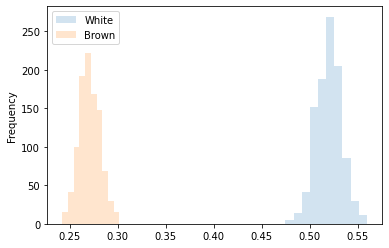

In [99]:
white_proportion_income_list.plot(kind='hist', alpha=.2, label="White")
brown_proportion_income_list.plot(kind='hist', alpha=.2, label="Brown")
plt.legend()
plt.show()

Let's calculate the p-value and the 'bootstrap equivalent' t-statistic for our hypothesis.

In [100]:
# compute the probability of h0
pvalue_boot_2 = (white_proportion_income_list <= brown_proportion_income_list).mean()

# Compute the bootstrap equivalent for the t-statistic
diff = white_proportion_income_list-brown_proportion_income_list
statistic_boot_2 = (diff.mean())/diff.std()

statistic_boot_2, pvalue_boot_2

(14.969384590281182, 0.0)

In [101]:
# Compare the p_value to the significance level
if (pvalue_boot_2 < alpha):
  print("Reject the Null Hypothesis.")
else:
  print("Fail to Reject the Null Hypothesis.")

Reject the Null Hypothesis.


**At the significance level of 0.05, we have evidence to reject the null hypothesis in favor of the alternative. The proportion of brazilian students with a family monthly income of more than two minimum wages is higher for those declared as white than for brown skin.**

### 4.3 - Do brazilian students declared themselves as brown skinned have higher average scores than those self declared as black?

To answer this question, we're going to perform the following hypothesis test:

$$H_0: \mu_{score\_brown} \le \mu_{score\_black}$$

$$H_1: \mu_{score\_brown} \gt \mu_{score\_black}$$

Again, we're going to generate 10.000 bootstrap means for each group, and use that to empirically create the sample distribution for the mean.

In [102]:
brown_mean_score_list, black_mean_score_list = get_bootstrap_means(df.query('SKIN_COLOR=="Brown"')['TOTAL_SCORE'], df.query('SKIN_COLOR=="Black"')['TOTAL_SCORE'])

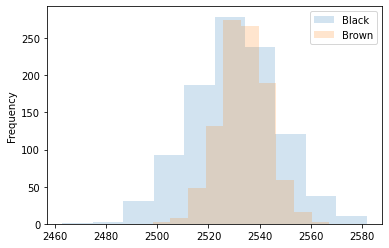

In [103]:
black_mean_score_list.plot(kind='hist', alpha=.2, label="Black")
brown_mean_score_list.plot(kind='hist', alpha=.2, label="Brown")
plt.legend()
plt.show()

Let's calculate the p-value and the 'bootstrap equivalent' t-statistic for our hypothesis.

In [104]:
# compute the probability of h0
pvalue_boot_3 = (brown_mean_score_list <= black_mean_score_list).mean()

# Compute the bootstrap equivalent for the t-statistic
diff = brown_mean_score_list-black_mean_score_list
statistic_boot_3 = (diff.mean())/diff.std()

statistic_boot_3, pvalue_boot_3

(0.17924542555120074, 0.429)

In [105]:
# Compare the p_value to the significance level
if (pvalue_boot_3 < alpha):
  print("Reject the Null Hypothesis.")
else:
  print("Fail to Reject the Null Hypothesis.")

Fail to Reject the Null Hypothesis.


**At the significance level of 0.05, we don't have evidence to reject the null hypothesis. Brazilian students self declared as brown skinned don't have higher average scores than those self declared as black.**

### 4.4 - Do brazilian students declared themselves as brown skinned have higher average family income than those self declared as black?

$$ H_0 : p_{income\_brown} \le p_{income\_black} $$

$$ H_1 : p_{income\_brown} \gt p_{income\__black} $$

Again, since we don't actually have the family average income information for each student (we only have information about the family income 'groups'), we'll use the proportion of families with higher income as a proxy to our goal.

In [106]:
brown_proportion_income_list, black_proportion_income_list = get_bootstrap_means(df.query('SKIN_COLOR=="Brown"')['AVERAGE_INCOME_MORE_2WAGES'], df.query('SKIN_COLOR=="Black"')['AVERAGE_INCOME_MORE_2WAGES'])

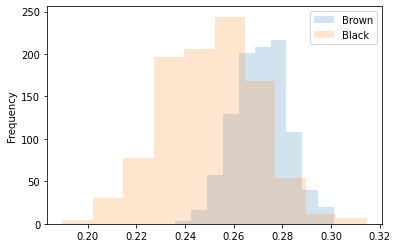

In [107]:
brown_proportion_income_list.plot(kind='hist', alpha=.2, label="Brown")
black_proportion_income_list.plot(kind='hist', alpha=.2, label="Black")
plt.legend()
plt.show()

Let's calculate the p-value and the 'bootstrap equivalent' t-statistic for our hypothesis.

In [108]:
# compute the probability of h0
pvalue_boot_4 = (brown_proportion_income_list <= black_proportion_income_list).mean()

# Compute the bootstrap equivalent for the t-statistic
diff = brown_proportion_income_list-black_proportion_income_list
statistic_boot_4 = (diff.mean())/diff.std()

statistic_boot_4, pvalue_boot_4

(0.9433367869526582, 0.174)

In [109]:
# Compare the p_value to the significance level
if (pvalue_boot_4 < alpha):
  print("Reject the Null Hypothesis.")
else:
  print("Fail to Reject the Null Hypothesis.")

Fail to Reject the Null Hypothesis.


**At the significance level of 0.05, we don't have evidence to reject the null hypothesis. The proportion of brazilian students with a family monthly income of more than two minimum wages is not higher for those declared as brown than for black.**

### 4.5 - Do brazilian female students have higher essay average scores than male students?

To answer this question, we're going to perform the following hypothesis test:

$$H_0: \mu_{score\_female} \le \mu_{score\_male}$$

$$H_1: \mu_{score\_female} \gt \mu_{score\_male}$$

Again, we're going to generate 10.000 bootstrap means for each group, and use that to empirically create the sample distribution for the mean.

In [110]:
female_mean_score_list, male_mean_score_list = get_bootstrap_means(df.query('GENDER=="Female"')['GRADE_ESSAY'], df.query('GENDER=="Male"')['GRADE_ESSAY'])

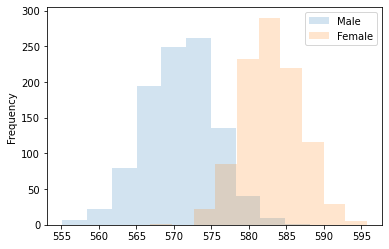

In [111]:
male_mean_score_list.plot(kind='hist', alpha=.2, label="Male")
female_mean_score_list.plot(kind='hist', alpha=.2, label="Female")
plt.legend()
plt.show()

Let's calculate the p-value and the 'bootstrap equivalent' t-statistic for our hypothesis.

In [112]:
# compute the probability of h0
pvalue_boot_5 = (female_mean_score_list <= male_mean_score_list).mean()

# compute the bootstrap equivalent for the t-statistic
diff = female_mean_score_list-male_mean_score_list
statistic_boot_5 = (diff.mean())/diff.std()

statistic_boot_5, pvalue_boot_5

(1.9446006973354393, 0.021)

In [113]:
# Compare the p_value to the significance level
if (pvalue_boot_5 < alpha):
  print("Reject the Null Hypothesis.")
else:
  print("Fail to Reject the Null Hypothesis.")

Reject the Null Hypothesis.


**At the significance level of 0.05, we have evidence to reject the null hypothesis in favor of the alternative. Brazilian female students have higher essay average scores than male students.**

### 4.6 - Do brazilian students who chose 'english' as a foreign language have higher language average scores than those who chose 'spanish'?

To answer this question, we're going to perform the following hypothesis test:

$$H_0: \mu_{score\_english} \le \mu_{score\_spanish}$$

$$H_1: \mu_{score\_english} \gt \mu_{score\_spanish}$$

In [114]:
english_mean_score_list, spanish_mean_score_list = get_bootstrap_means(df.query('FOREIGN_LANGUAGE=="English"')['GRADE_LANGUAGE_SCIENCES'], df.query('FOREIGN_LANGUAGE=="Spanish"')['GRADE_LANGUAGE_SCIENCES'])

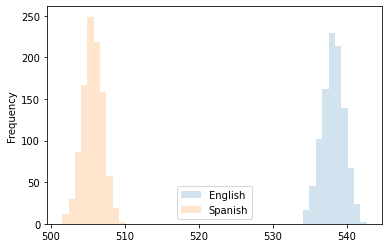

In [115]:
english_mean_score_list.plot(kind='hist', alpha=.2, label="English")
spanish_mean_score_list.plot(kind='hist', alpha=.2, label="Spanish")
plt.legend()
plt.show()

Let's calculate the p-value and the 'bootstrap equivalent' t-statistic for our hypothesis.

In [116]:
# compute the probability of h0
pvalue_boot_6 = (english_mean_score_list <= spanish_mean_score_list).mean()

# compute the bootstrap equivalent for the t-statistic
diff = english_mean_score_list-spanish_mean_score_list
statistic_boot_6 = (diff.mean())/diff.std()

statistic_boot_6, pvalue_boot_6

(16.043134376193926, 0.0)

In [117]:
# Compare the p_value to the significance level
if (pvalue_boot_6 < alpha):
  print("Reject the Null Hypothesis.")
else:
  print("Fail to Reject the Null Hypothesis.")

Reject the Null Hypothesis.


**At the significance level of 0.05, we have evidence to reject the null hypothesis in favor of the alternative. Brazilian students who pick english as their prefered foreing language have higher language average scores than those who pick spanish.**

## 5. Two Sample T-Test Hypothesis Tests

Just for future reference, let's test the same above hypothesis using the "standard two sample t-test approach", and see how these results compare to the bootstrap ones.

In [128]:
def perform_one_sided_two_sample_ttest(group1, group2):

    # performe the levene test to check if the variances are statistically equal or not,
    _, pvalue_levene = stats.levene(group1, group2)

    # use levene's result to decide if the variances are equal or not 
    levene_result = pvalue_levene < alpha

    # use scipy.stats to perform a "two-sample t-test"
    statistic_ttest, pvalue_ttest = stats.ttest_ind(group1, group2, equal_var=levene_result)

    # divide the p-value by 2, bcs we're interested in only one side of the t-distribution curve
    pvalue_ttest /= 2

    # compare the p_value to the significance level
    if (pvalue_ttest < alpha):
      print("Reject the Null Hypothesis.")
    else:
      print("Fail to Reject the Null Hypothesis.")

    # return the ttest statistic, and pvalue (rounded)
    return statistic_ttest, np.round(pvalue_ttest, 4)

### 5.1. Do brazilian students declared themselves as white skinned have higher average scores than those self declared as brown skinned?

$$ H_0 : \mu_{score\_white} \le \mu_{score\_brown} $$

$$ H_1 : \mu_{score\_white} \gt \mu_{score\_brown} $$

In [158]:
statistic_ttest_1, pvalue_ttest_1 = perform_one_sided_two_sample_ttest(df.query('SKIN_COLOR=="White"')['TOTAL_SCORE'], df.query('SKIN_COLOR=="Brown"')['TOTAL_SCORE'])
statistic_ttest_1, pvalue_ttest_1

Reject the Null Hypothesis.


(12.942333582285, 0.0)

###5.2. Do brazilian students declared themselves as white skinned have higher average family income than those self declared as brown skinned?

$$ H_0 : p_{income\_white} \le p_{income\_brown} $$

$$ H_1 : p_{income\_white} \gt p_{income\_brown} $$

In [156]:
statistic_ttest_2, pvalue_ttest_2 = perform_one_sided_two_sample_ttest(df.query('SKIN_COLOR=="White"')['AVERAGE_INCOME_MORE_2WAGES'], df.query('SKIN_COLOR=="Brown"')['AVERAGE_INCOME_MORE_2WAGES'])
statistic_ttest_2, pvalue_ttest_2

Reject the Null Hypothesis.


(14.528453542017967, 0.0)

### 5.3 - Do brazilian students declared themselves as brown skinned have higher average scores than those self declared as black?

$$H_0: \mu_{score\_brown} \le \mu_{score\_black}$$

$$H_1: \mu_{score\_brown} \gt \mu_{score\_black}$$

In [155]:
statistic_ttest_3, pvalue_ttest_3 = perform_one_sided_two_sample_ttest(df.query('SKIN_COLOR=="Brown"')['TOTAL_SCORE'], df.query('SKIN_COLOR=="Black"')['TOTAL_SCORE'])
statistic_ttest_3, pvalue_ttest_3

Fail to Reject the Null Hypothesis.


(0.13423711617073125, 0.4466)

### 5.4 - Do brazilian students declared themselves as brown skinned have higher average family income than those self declared as black?

$$ H_0 : p_{income\_brown} \le p_{income\_black} $$

$$ H_1 : p_{income\_brown} \gt p_{income\__black} $$

In [154]:
statistic_ttest_4, pvalue_ttest_4 = perform_one_sided_two_sample_ttest(df.query('SKIN_COLOR=="Brown"')['AVERAGE_INCOME_MORE_2WAGES'], df.query('SKIN_COLOR=="Black"')['AVERAGE_INCOME_MORE_2WAGES'])
statistic_ttest_4, pvalue_ttest_4

Fail to Reject the Null Hypothesis.


(0.9194592959107435, 0.1791)

### 5.5 - Do brazilian female students have higher essay average scores than male students?

$$H_0: \mu_{score\_female} \le \mu_{score\_male}$$

$$H_1: \mu_{score\_female} \gt \mu_{score\_male}$$

In [153]:
statistic_ttest_5, pvalue_ttest_5 = perform_one_sided_two_sample_ttest(df.query('GENDER=="Female"')['GRADE_ESSAY'], df.query('GENDER=="Male"')['GRADE_ESSAY'])
statistic_ttest_5, pvalue_ttest_5

Reject the Null Hypothesis.


(1.9839730332139998, 0.0237)

### 5.6 - Do brazilian students who chose 'english' as a foreign language have higher language average scores than those who chose 'spanish'?

$$H_0: \mu_{score\_english} \le \mu_{score\_spanish}$$

$$H_1: \mu_{score\_english} \gt \mu_{score\_spanish}$$

In [152]:
statistic_ttest_6, pvalue_ttest_6 = perform_one_sided_two_sample_ttest(df.query('FOREIGN_LANGUAGE=="English"')['GRADE_LANGUAGE_SCIENCES'], df.query('FOREIGN_LANGUAGE=="Spanish"')['GRADE_LANGUAGE_SCIENCES'])
statistic_ttest_6, pvalue_ttest_6

Reject the Null Hypothesis.


(15.965680380827736, 0.0)

## 6. Results

How do the empirical (bootstrap) and 'standard' (t-test) results compare in our cases?

In [159]:
# create a dataframe with the results
summary_df = pd.DataFrame({"Hypothesis":[1, 2, 3, 4, 5, 6], 
                          "Bootstrap Statistic":[statistic_boot_1, statistic_boot_2, statistic_boot_3, statistic_boot_4, statistic_boot_5, statistic_boot_6],
                          "T-Test Statistic":[statistic_ttest_1, statistic_ttest_2, statistic_ttest_3, statistic_ttest_4, statistic_ttest_5, statistic_ttest_6],
                          "Bootstrap P-Value":[pvalue_boot_1, pvalue_boot_2, pvalue_boot_3, pvalue_boot_4, pvalue_boot_5, pvalue_boot_6],
                          "T-Test P-Value":[pvalue_ttest_1, pvalue_ttest_2, pvalue_ttest_3, pvalue_ttest_4, pvalue_ttest_5, pvalue_ttest_6]}, )

# define the 'Hypothesis' column as our index
summary_df.set_index('Hypothesis', inplace=True)

# Compare the Bootstrap Pvalues to the significance level
summary_df['Bootstrap Conclusion'] = (df_compare['Bootstrap P-Value'] < alpha).map({True:"Reject H0",
                                                                                    False:"Fail to Reject H0"})

# Compare the T-Test Pvalues to the significance level
summary_df['T-Test Conclusion'] = (df_compare['T-Test P-Value'] < alpha).map({True:"Reject H0",
                                                                              False:"Fail to Reject H0"})

summary_df

,Bootstrap Statistic,T-Test Statistic,Bootstrap P-Value,T-Test P-Value,Bootstrap Conclusion,T-Test Conclusion
Hypothesis,,,,,,
1,12.797580,12.942334,0.000,0.0000,Reject H0,Reject H0
2,14.969385,14.528454,0.000,0.0000,Reject H0,Reject H0
3,0.179245,0.134237,0.429,0.4466,Fail to Reject H0,Fail to Reject H0
4,0.943337,0.919459,0.174,0.1791,Fail to Reject H0,Fail to Reject H0
5,1.944601,1.983973,0.021,0.0237,Reject H0,Reject H0
6,16.043134,15.965680,0.000,0.0000,Reject H0,Reject H0


## 7. Conclusions

At the significance level of 0.05, we have evidence to conclude that:

1. Brazilian students self declared as white skinned have higher average scores than those with brown skin.
2. The proportion of brazilian students with a family monthly income of more than two minimum wages is higher for those declared as white than for brown skin.
3. Brazilian students self declared as brown skinned don't have higher average scores than those self declared as black.
4. The proportion of brazilian students with a family monthly income of more than two minimum wages is not higher for those declared as brown than for black.
5. Brazilian female students have higher essay average scores than male students.
6. Brazilian students who pick english as their prefered foreing language have higher language average scores than those who pick spanish.